https://archive.ics.uci.edu/dataset/186/wine+quality

In [1]:
# set up Python
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LinearRegression, LogisticRegression
from wvu.util import plot_roc
from scipy.stats import spearmanr
from rank_plotting_fns import build_line_frame
from plotnine import *

In [2]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
wine_data = wine_quality.data.features 
wine_targets = wine_quality.data.targets 

In [3]:
wine_data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [4]:
wine_data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [5]:
wine_targets['quality'].value_counts()


quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [6]:
# build preference we are trying to learn
taste_model_linear = LinearRegression()
taste_model_linear.fit(wine_data, wine_targets['quality'])
beta_linear = taste_model_linear.coef_

beta_linear

array([ 6.76839156e-02, -1.32789221e+00, -1.09656648e-01,  4.35587507e-02,
       -4.83713531e-01,  5.96988830e-03, -2.48129841e-03, -5.49669422e+01,
        4.39296072e-01,  7.68251760e-01,  2.67030009e-01])

In [7]:
# build preference we are trying to learn
taste_model_logistic = LogisticRegression(max_iter=10000, solver='newton-cholesky')
taste_model_logistic.fit(wine_data, wine_targets['quality'] >= 7)
beta_logistic = taste_model_logistic.coef_

beta_logistic

array([[ 9.67224656e-02, -3.95166938e+00, -3.21613718e-01,
         5.93694185e-02, -2.25915415e+00,  1.26702308e-02,
        -3.83915057e-03, -1.60778550e-01,  7.65764642e-01,
         1.48647142e+00,  9.47623295e-01]])

In [8]:
wine_scores = pd.DataFrame({
    'linear_score': taste_model_linear.predict(wine_data),
    'logistic_score': wine_data @ taste_model_logistic.coef_[0],
    'quality': wine_targets['quality'],
    })

wine_scores

,linear_score,logistic_score,quality
0,4.997607,10.167017,5
1,4.924993,9.857154,5
2,5.034663,10.238760,5
3,5.680333,12.133352,6
4,4.997607,10.167017,5
...,...,...,...
6492,6.168984,13.335641,6
6493,5.608278,11.737215,5
6494,5.419361,11.273261,6
6495,6.432656,14.229339,7


<Figure size 640x480 with 0 Axes>

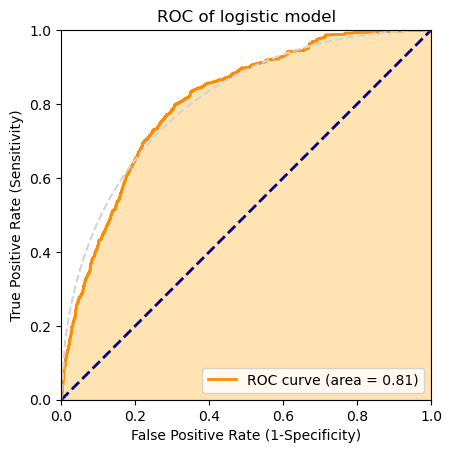

0.806877199614758

In [9]:
plot_roc(
    prediction=wine_scores['logistic_score'],
    istrue=wine_scores['quality'] >= 7,
    ideal_line_color='lightgrey',
    title=f'ROC of logistic model',
)

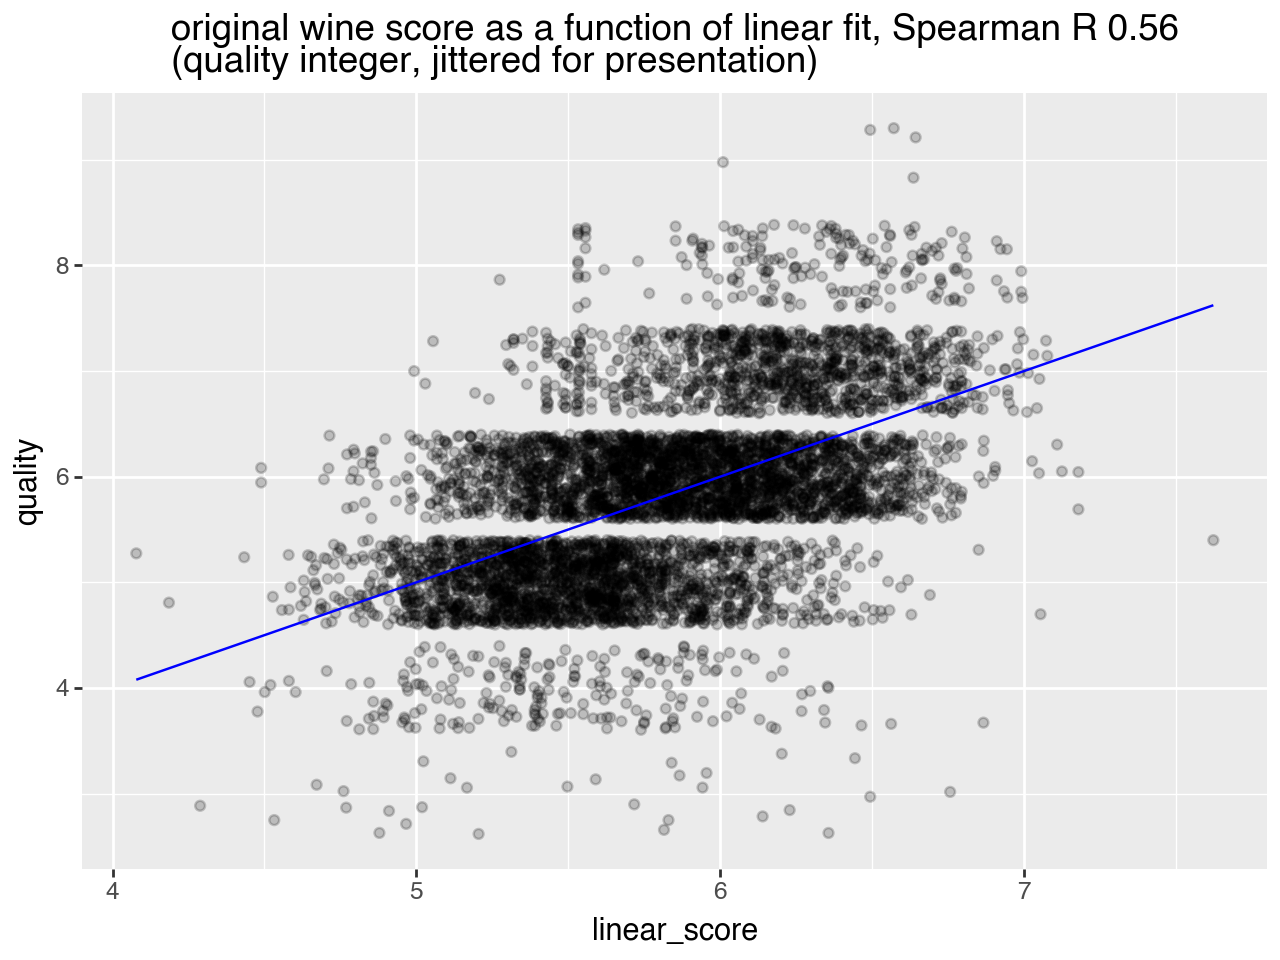

In [10]:

spearman_r = spearmanr(
    wine_scores['linear_score'],
    wine_scores['quality'],
)
fit_frame = build_line_frame(wine_scores, xcol='linear_score', ycol='quality')
(
    ggplot(
        data=wine_scores,
        mapping=aes(x='linear_score', y='quality'),
    )
    + geom_jitter(alpha=0.2, width=0)
    + geom_line(data=fit_frame, color='blue')
    + ggtitle(f"original wine score as a function of linear fit, Spearman R {spearman_r.statistic:.2f}\n(quality integer, jittered for presentation)")
)

In [11]:
# save 
wine_data.to_csv('uci_wine_example_features.csv', index=False)
wine_scores.to_csv('uci_wine_example_scores.csv', index=False)